In [2]:
import matplotlib.pyplot as plt
import numpy as np
import sys

sys.path.append('./../../code/')
from dn_utils.behavioral_models import (load_behavioral_data, 
    estimate_values_pd, estimate_regressors)

In [7]:
def estimate_regressors(beh, meta, subject, condition, val):
    '''Calculate trial-wise regressors for chosen option.

    Args:
        beh (np.array): aggregated behavioral responses
        meta (dict): description of beh array coding
        subject (int): subject index
        condition (int): task condition index
        val (np.array): reflects algorithm trialwise beliefs about
            probabilities that box will be chosen (rewarded / punished)

    Returns (3-tuple):
        anticip_pwin (np.arry): expected probability of choosing correct box
        anticip_rew (np.arry): pascalian expected value
        pred_err (np.array): prediction error
    '''
    rewarded = np.copy(beh[subject, condition, :, meta['dim4'].index('rwd')])
    response = np.copy(beh[subject, condition, :, meta['dim4'].index('response')])
    magn_both = np.hstack((
        np.copy(beh[subject, condition, :, meta['dim4'].index('magn_left')])[:, np.newaxis],
        np.copy(beh[subject, condition, :, meta['dim4'].index('magn_right')])[:, np.newaxis],
    ))

    response_mask = np.hstack((
        response.reshape(-1, 1) == -1, 
        response.reshape(-1, 1) == 1
    ))

    # Ensure correct val interpretation
    anticip_val = np.sum(np.multiply(val, response_mask), axis=1) # bci
    if condition == 1:
        val = np.fliplr(val) # change bci interpretation to correct interpretation
        rewarded *= (-1)
    anticip_pwin = np.sum(np.multiply(val, response_mask), axis=1) # correct interpretation
    
    anticip_rew = np.sum(magn_both * response_mask, 1) * anticip_val
    pred_err = (rewarded == response) - anticip_pwin

    return anticip_pwin, anticip_rew, pred_err

In [3]:
def plot_trial_regressor(beh, meta, sub, con, regressor) -> None:
    '''Plot prediction error time-course for single task.
    
    Args:
        beh (np.array): aggregated behavioral responses
        meta (dict): description of beh array coding
        subject (int): subject index
        condition (int): task condition index
        regressor (np.arrary): trialwise regressor values
    '''
    fig, ax = plt.subplots(nrows=1, ncols=1, facecolor='w', figsize=(20, 3))
    
    block = beh[sub, con, :, meta['dim4'].index('block')]
    trials = np.arange(n_trials) + 1

    ax.plot(0)
    ax.plot(trials, regressor, color='grey')
    ax.plot(
        trials[regressor > 0], 
        regressor[regressor > 0],
        linewidth=0,
        marker='o',
        markersize=5,
        color='g',
    )
    ax.plot(
        trials[regressor < 0], 
        regressor[regressor < 0],
        linewidth=0,
        marker='o',
        markersize=5,
        color='r',
    )
    ax.plot(
        trials[regressor == 0],
        regressor[regressor == 0],
        linewidth=0,
        marker='o',
        markersize=5,
        color='orange',
    )

    # ax.set_ylim([-1.1, 1.1])
    ax.set_xlim([0, n_trials + 1])
    ax.set_xticks(np.concatenate((np.nonzero(np.diff(block))[0] + 2, [1, 110])))
    ax.grid()

### Observation
Usually subjects are trying to minimize overal prediction error. Here it is not precisely the case, because sometimes subject pick probabilistically worse option to maximize their winnings.

In [4]:
# Load data
beh_path = '/home/kmb/Desktop/Neuroscience/Projects/BONNA_decide_net/' \
           'data/main_fmri_study/sourcedata/behavioral'
param_path = '/home/kmb/Desktop/Neuroscience/Projects/BONNA_decide_net/' \
             'code/behavioral_analysis/matjags-dn/data/alpha_pdci_mle.npy'

beh, meta = load_behavioral_data(beh_path)
alpha_pdci_mle = np.load(param_path)

n_subjects = len(meta['dim1'])
n_conditions = len(meta['dim2'])
n_trials = len(meta['dim3'])

Shape of beh array: (32, 2, 110, 21)
Conditions [(0, 'rew'), (1, 'pun')]
Columns: [(0, 'block'), (1, 'rwd'), (2, 'magn_left'), (3, 'magn_right'), (4, 'response'), (5, 'rt'), (6, 'won_bool'), (7, 'won_magn'), (8, 'acc_after_trial'), (9, 'onset_iti'), (10, 'onset_iti_plan'), (11, 'onset_iti_glob'), (12, 'onset_dec'), (13, 'onset_dec_plan'), (14, 'onset_dec_glob'), (15, 'onset_isi'), (16, 'onset_isi_plan'), (17, 'onset_isi_glob'), (18, 'onset_out'), (19, 'onset_out_plan'), (20, 'onset_out_glob')]


### Calculate and save PE regressors.

In [8]:
pe_regressors = np.zeros((n_subjects, n_conditions, n_trials))
epw_regressors = np.zeros((n_subjects, n_conditions, n_trials))
erew_regressors = np.zeros((n_subjects, n_conditions, n_trials))

for sub in range(n_subjects):
    
    for con in range(n_conditions):
        
        val = estimate_values_pd(
            beh, meta, sub, con,
            alpha_plus=alpha_pdci_mle[sub, 0], 
            alpha_minus=alpha_pdci_mle[sub, 1]
        )
        
        anticip_pwin, anticip_rew, pred_err = estimate_regressors(
            beh, meta, sub, con, val
        )
        
        epw_regressors[sub, con, :] = anticip_pwin
        erew_regressors[sub, con, :] = anticip_rew
        pe_regressors[sub, con, :] = pred_err

        
np.save('data/pe_regressors', pe_regressors)
np.save('data/epw_regressors', epw_regressors)
np.save('data/erew_regressors', erew_regressors)

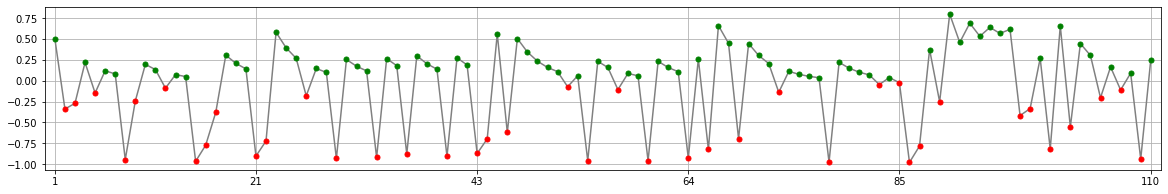

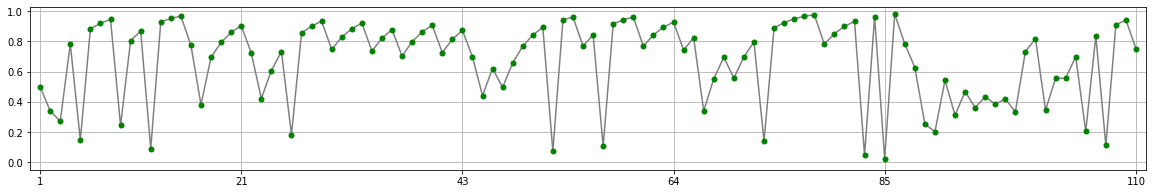

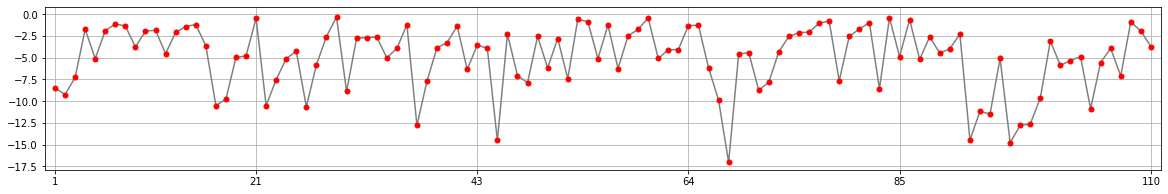

In [11]:
# Plot example regressors
sub = 0
con = 1

plot_trial_regressor(beh, meta, sub, con, pe_regressors[sub, con, :])
plot_trial_regressor(beh, meta, sub, con, epw_regressors[sub, con, :])
plot_trial_regressor(beh, meta, sub, con, erew_regressors[sub, con, :])